In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import librosa
import librosa.display

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [3]:
data=pd.read_csv("archive/speakers_all.csv",index_col='speakerid')
data = data.iloc[:,:8]
data = data[data['file_missing?']==False]
data

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
418,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,south africa,False
1159,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,south africa,False
1432,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,south africa,False
...,...,...,...,...,...,...,...,...
766,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,nigeria,False
851,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,nigeria,False
2023,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,nigeria,False


In [4]:
INPUT_DIR = 'archive/recordings/recordings'
OUTPUT_DIR = 'results'
parent_list = os.listdir(INPUT_DIR)

print(set(data['filename']+'.mp3') - set(parent_list))

data = data.drop(data[data['filename']=='sinhalese1'].index)
data = data.drop(data[data['filename']=='nicaragua'].index)
data

{'sinhalese1.mp3', 'nicaragua.mp3'}


,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
418,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,south africa,False
1159,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,south africa,False
1432,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,south africa,False
...,...,...,...,...,...,...,...,...
766,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,nigeria,False
851,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,nigeria,False
2023,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,nigeria,False


In [ ]:
# MFCC Trial

SAMPLE_RATE = 22050
fname_f = 'archive/recordings/recordings/' + 'english385.mp3'

y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 20)# Chop audio at 10 secs...
mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc = 13)# 10 MFCC components

plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()
print(mfcc.shape,y.shape,sr)

In [ ]:
#features = feature_extractor(parent_list, feature_type='mfcc')

features = np.zeros(shape=(2138,10,862))
i=0
SAMPLE_RATE = 22050
dire = 'archive/recordings/recordings/'
for file in parent_list[:]:
    f_name = str(dire+file)
    y, sr = librosa.load(f_name, sr=SAMPLE_RATE, duration = 20 )     # duration 10s
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc =10)
    if len(mfcc[1]) < 862:
        offset = 862 - len(mfcc[1])
        mfcc= np.pad(mfcc,((0,0),(offset,0)), 'constant')
        
    features[i,:,:]=mfcc
    i+=1

In [ ]:
np.save("features.npy",features)

In [5]:
X = np.load("features.npy")
print(np.shape(X))

(2138, 10, 862)


In [6]:
y_accent = data['native_language']

encoder1 = LabelEncoder()
encoder1.fit(y_accent)
y_accent_ = encoder1.transform(y_accent)
y_accent_ = to_categorical(np.array(y_accent_),dtype='float32')
print(np.shape(y_accent_))  #200 categories.

(2138, 200)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_accent_train, y_accent_test = train_test_split(X, y_accent_, test_size=0.2, random_state=10)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train= np.expand_dims(X_train, axis=3)
X_test= np.expand_dims(X_test, axis=3)

#X_train, X_val, y_accent_train, y_accent_val = train_test_split(X_train, y_accent_train, test_size=0.15, random_state=10)
#X_val = (X_val - mean)/std
#X_val= np.expand_dims(X_val, axis=3)

print ('Train set:', X_train.shape,  y_accent_train.shape)
print ('Test set:', X_test.shape,  y_accent_test.shape)
#print ('validation set:', X_val.shape,  y_accent_val.shape)

Train set: (1710, 10, 862, 1) (1710, 200)
Test set: (428, 10, 862, 1) (428, 200)


# CNN CLASSIFICATION

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Input, Conv2D, BatchNormalization, MaxPooling2D, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
#from keras.regularizers import l2
#from keras.callbacks import (EarlyStopping, LearningRateScheduler,ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(10, 862, 1), name='Input'))

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(200, activation='softmax'))


In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

model.compile( loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
num_epochs = 35
num_batch_size = 10
history = model.fit(X_train, y_accent_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_accent_test), verbose=1)


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()


# 4 Classification

In [27]:
English = data[data['native_language']=='english']
French = data[data['native_language']=='french']
Spanish= data[data['native_language']=='spanish']
Arabic = data[data['native_language']=='arabic']
datanew = English.append(French).append(Spanish).append(Arabic)
datanew

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
61,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,usa,False
62,35.0,0.0,"davenport, iowa, usa",english10,english,female,usa,False
63,23.0,0.0,"miami, florida, usa",english100,english,female,usa,False
64,18.0,0.0,"toronto, ontario, canada",english101,english,female,canada,False
65,22.0,0.0,"torrington, connecticut, usa",english102,english,male,usa,False
...,...,...,...,...,...,...,...,...
2143,31.0,10.0,"kuwait city, kuwait",arabic95,arabic,female,kuwait,False
2153,21.0,7.0,"riyadh, saudi arabia",arabic96,arabic,male,saudi arabia,False
2154,19.0,4.0,"sharjah, united arab emirates",arabic97,arabic,female,united arab emirates,False


In [26]:
parent_list_new = datanew['filename']+ '.mp3'

#features = feature_extractor(parent_list, feature_type='mfcc')

features = np.zeros(shape=(906,10,862))
i=0
SAMPLE_RATE = 22050
dire = 'archive/recordings/recordings/'
for file in parent_list_new[:]:
    f_name = str(dire+file)
    y, sr = librosa.load(f_name, sr=SAMPLE_RATE, duration = 20 )     # duration 10s
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc =10)
    if len(mfcc[1]) < 862:
        offset = 862 - len(mfcc[1])
        mfcc= np.pad(mfcc,((0,0),(offset,0)), 'constant')
        
    features[i,:,:]=mfcc
    i+=1


D:\AI\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


KeyboardInterrupt: 

In [5]:
np.save("features_4class.npy",features)

In [91]:
X = np.load("features_4class.npy")
print(np.shape(X))

(906, 10, 862)


In [92]:
#PCA 
from sklearn.decomposition import PCA
proj = np.zeros(shape=(906,10,862))

for i in range(906):
    X1 = X[i,:,:]
    pca = PCA(whiten=True)
    X_pca = pca.fit_transform(X1)
    proj[i,:,:] = pca.inverse_transform(X_pca)

X = proj

In [93]:
y_accent = datanew['native_language']

encoder1 = LabelEncoder()
encoder1.fit(y_accent)
y_accent_ = encoder1.transform(y_accent)
y_accent_ = to_categorical(np.array(y_accent_),dtype='float32')
print(np.shape(y_accent_))  #4 categories.

(906, 4)


In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_accent_train, y_accent_test = train_test_split(X, y_accent_, test_size=0.2, random_state=10)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train= np.expand_dims(X_train, axis=3)
X_test= np.expand_dims(X_test, axis=3)

#X_train, X_val, y_accent_train, y_accent_val = train_test_split(X_train, y_accent_train, test_size=0.15, random_state=10)
#X_val = (X_val - mean)/std
#X_val= np.expand_dims(X_val, axis=3)

print ('Train set:', X_train.shape,  y_accent_train.shape)
print ('Test set:', X_test.shape,  y_accent_test.shape)
#print ('validation set:', X_val.shape,  y_accent_val.shape)

Train set: (724, 10, 862, 1) (724, 4)
Test set: (182, 10, 862, 1) (182, 4)


In [95]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Input, Conv2D, BatchNormalization, MaxPooling2D, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
#from keras.regularizers import l2
#from keras.callbacks import (EarlyStopping, LearningRateScheduler,ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

In [96]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(10, 862, 1), name='Input'))

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [97]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 862, 32)       320       
                                                                 
 batch_normalization_12 (Bat  (None, 10, 862, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 431, 32)       0         
 )                                                               
                                                                 
 batch_normalization_13 (Bat  (None, 5, 431, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 431, 32)        9248      
                                                     

In [98]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

model.compile( loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
num_epochs = 35
num_batch_size = 10
history = model.fit(X_train, y_accent_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_accent_test), verbose=1)

Epoch 1/35
73/73 [==============================] - 8s 87ms/step - loss: 1.8302 - accuracy: 0.3881 - val_loss: 1.8878 - val_accuracy: 0.1703
Epoch 2/35
73/73 [==============================] - 5s 62ms/step - loss: 1.2162 - accuracy: 0.5180 - val_loss: 2.9784 - val_accuracy: 0.1703
Epoch 3/35
73/73 [==============================] - 5s 66ms/step - loss: 0.9954 - accuracy: 0.6450 - val_loss: 1.7163 - val_accuracy: 0.1758
Epoch 4/35
73/73 [==============================] - 5s 62ms/step - loss: 0.7175 - accuracy: 0.7431 - val_loss: 1.2004 - val_accuracy: 0.5165
Epoch 5/35
73/73 [==============================] - 5s 64ms/step - loss: 0.5414 - accuracy: 0.8094 - val_loss: 1.2470 - val_accuracy: 0.5385
Epoch 6/35
73/73 [==============================] - 4s 58ms/step - loss: 0.3842 - accuracy: 0.8605 - val_loss: 1.1031 - val_accuracy: 0.6099
Epoch 7/35
73/73 [==============================] - 5s 65ms/step - loss: 0.2803 - accuracy: 0.9130 - val_loss: 0.9559 - val_accuracy: 0.7088
Epoch 8/35
73

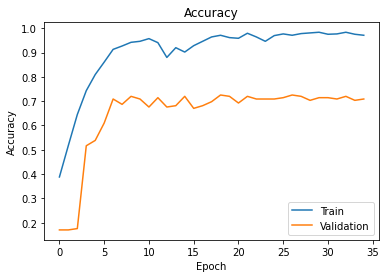

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()


# LSTM

In [36]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [100]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(10, 862), name='Input'))

model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))          
model.add(tf.keras.layers.Dense(4,activation='softmax'))
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 64)                237312    
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 4)                 260       
                                                                 
Total params: 237,828
Trainable params: 237,700
Non-trainable params: 128
_________________________________________________________________
None


In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

model.compile( loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
num_epochs = 35
num_batch_size = 10
history = model.fit(X_train, y_accent_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_accent_test), verbose=1)


Epoch 1/35
73/73 [==============================] - 4s 20ms/step - loss: 1.8998 - accuracy: 0.3122 - val_loss: 1.2263 - val_accuracy: 0.4945
Epoch 2/35
73/73 [==============================] - 1s 11ms/step - loss: 1.2659 - accuracy: 0.5014 - val_loss: 1.0834 - val_accuracy: 0.5604
Epoch 3/35
73/73 [==============================] - 1s 11ms/step - loss: 0.8817 - accuracy: 0.6630 - val_loss: 1.0476 - val_accuracy: 0.5824
Epoch 4/35
73/73 [==============================] - 1s 11ms/step - loss: 0.7743 - accuracy: 0.7155 - val_loss: 1.0771 - val_accuracy: 0.6154
Epoch 5/35
73/73 [==============================] - 1s 10ms/step - loss: 0.5515 - accuracy: 0.8066 - val_loss: 1.1015 - val_accuracy: 0.6319
Epoch 6/35
73/73 [==============================] - 1s 10ms/step - loss: 0.4925 - accuracy: 0.8425 - val_loss: 1.1734 - val_accuracy: 0.5989
Epoch 7/35
73/73 [==============================] - 1s 10ms/step - loss: 0.4122 - accuracy: 0.8425 - val_loss: 1.1754 - val_accuracy: 0.6154
Epoch 8/35
73

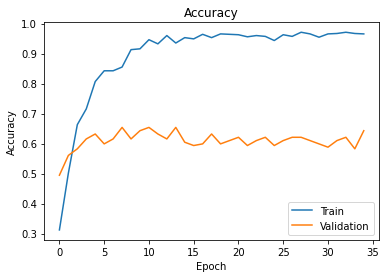

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()
